In [33]:
from pathlib import Path
import numpy as np
import pandas as pd
import utils
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torch.utils.data import WeightedRandomSampler



def create_df(train_images_path):
    train_label_path = train_images_path.parent/'labels'
    val_data_path = train_images_path.parent.parent/'val/images'
    val_label_path = val_data_path.parent/'labels'
    train_images, train_labels, bbox = [], [], []
    for lbl in train_label_path.glob('*.txt'):
        coord = utils.read_label_txt(train_label_path/lbl)
        if len(coord) != 0:
            train_labels.append('bifurcation')
            bbox.append(coord)
        else:
            train_labels.append('background')
            bbox.append('')
        train_images.append('_'.join(lbl.parts[-1].split('.')[0:-1]))
    imbalanced_train_df = pd.DataFrame(data={'image': train_images, 'label': train_labels, 'bbox': bbox})

    val_images, val_labels = [], []
    for lbl in val_label_path.glob('*.txt'):
        if len(utils.read_label_txt(val_label_path/lbl)) != 0:
            val_labels.append('bifurcation')
        else:
            val_labels.append('background')
        val_images.append('_'.join(lbl.parts[-1].split('.')[0:-1]))
    val_df = pd.DataFrame(data={'image': val_images, 'label': val_labels})
    return imbalanced_train_df, val_df

dataset_path = Path('/Users/aibotasanatbek/Documents/projects/calcium_scoring/data/datasets/train_val/split_2/split_2_dataset.yaml')

train_images_path = dataset_path.parent/'train/images'

imbalanced_train_df, val_df = create_df(train_images_path)

print('Train distribution')
print(imbalanced_train_df.label.value_counts())
print('==============')
print('Validation distribution')
print(val_df.label.value_counts())

label_to_id = {'bifurcation': 0, 'background': 1}
num_classes = len(label_to_id)

print("labels: ", label_to_id)


Train distribution
label
background     336
bifurcation     56
Name: count, dtype: int64
Validation distribution
label
bifurcation    3
Name: count, dtype: int64
labels:  {'bifurcation': 0, 'background': 1}


In [34]:
ds = TensorDataset(torch.as_tensor([(idx, label_to_id[l]) for idx, l in enumerate(imbalanced_train_df.label.values)]))
dl = DataLoader(ds, shuffle=True, batch_size=16)

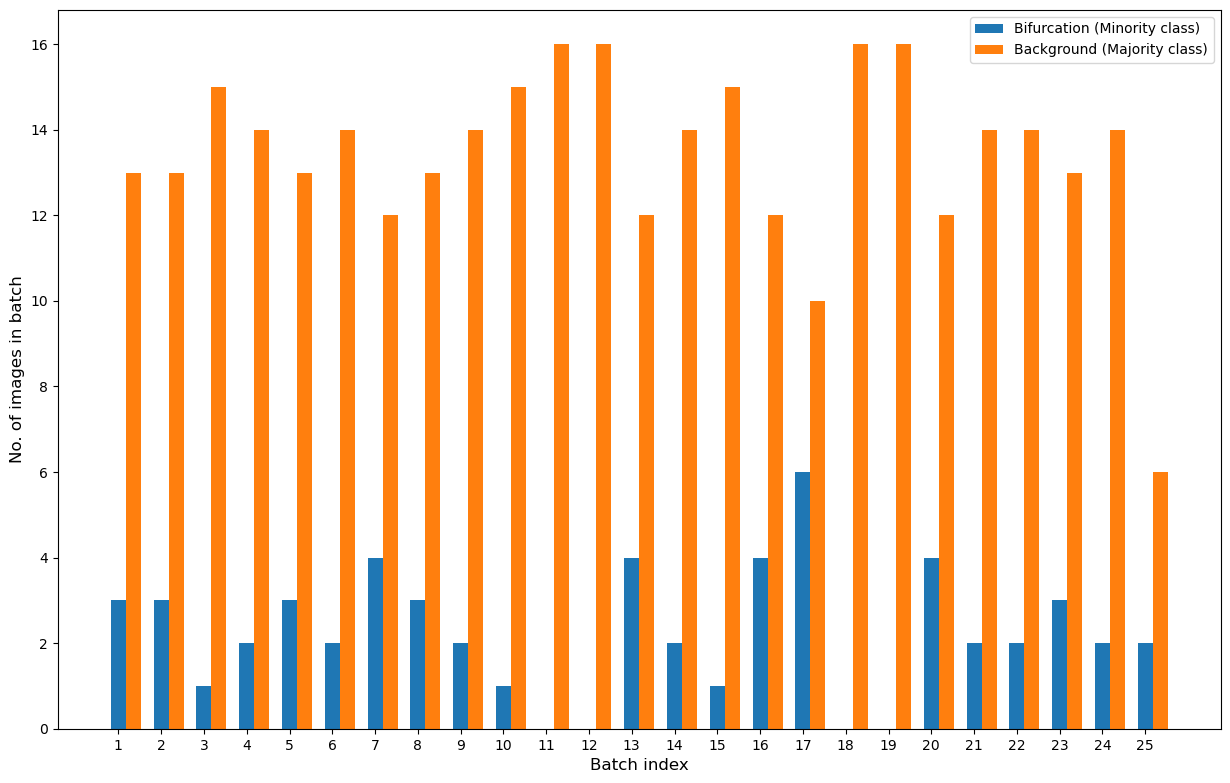

Avg Proportion of Bifurcation (Minority class) per batch: 0.22400000000000003
Avg Proportion of Background (Majority class) per batch: 1.344
Num. unique images seen: 392/392


In [35]:

def visualise_dataloader(dl, id_to_label=None, with_outputs=True):
    total_num_images = len(dl.dataset)
    idxs_seen = []
    class_0_batch_counts = []
    class_1_batch_counts = []
    for i, batch in enumerate(dl):
        idxs = batch[0][:, 0].tolist()
        classes = batch[0][:, 1]
        class_ids, class_counts = classes.unique(return_counts=True)
        class_ids = set(class_ids.tolist())
        class_counts = class_counts.tolist()
        idxs_seen.extend(idxs)
        if len(class_ids) == 2:
            class_0_batch_counts.append(class_counts[0])
            class_1_batch_counts.append(class_counts[1])
        elif len(class_ids) == 1 and 0 in class_ids:
            class_0_batch_counts.append(class_counts[0])
            class_1_batch_counts.append(0)
        elif len(class_ids) == 1 and 1 in class_ids:
            class_0_batch_counts.append(0)
            class_1_batch_counts.append(class_counts[0])   
        else:
            raise ValueError('More than two classes detected')
    if with_outputs:
        fig, ax = plt.subplots(1, figsize=(15, 15))
        ind = np.arange(len(class_0_batch_counts))
        width = 0.35  
        ax.bar(ind, class_0_batch_counts, width, label=(id_to_label[0] if id_to_label is not None else '0'))
        ax.bar(ind + width, class_1_batch_counts, width, label=(id_to_label[1] if id_to_label is not None else '1'))
        ax.set_xticks(ind, ind+1)
        ax.set_xlabel('Batch index', fontsize=12)
        ax.set_ylabel('No. of images in batch', fontsize=12)
        ax.set_aspect('equal')
        plt.legend()
        plt.show()
        num_images_seen = len(idxs_seen)
        print(f'Avg Proportion of {(id_to_label[0] if id_to_label is not None else "Class 0")} per batch: {(np.array(class_0_batch_counts)/10).mean()}')
        print(f'Avg Proportion of {(id_to_label[1] if id_to_label is not None else "Class 1")} per batch: {(np.array(class_1_batch_counts)/10).mean()}')
        print('=============')
        print(f'Num. unique images seen: {len(set(idxs_seen))}/{total_num_images}')
    return class_0_batch_counts, class_1_batch_counts, idxs_seen

class_0_batch_counts, class_1_batch_counts, idxs_seen = visualise_dataloader(dl, 
                                                                             {0: "Bifurcation (Minority class)",
                                                                              1: "Background (Majority class)"})

From this, we can clearly observe the effects of the imbalance, as some batches don't contain any images from our minority class at all! Additionally, we can see that every image in our dataset would been seen during training. When we take the average representation across all batches, we observe the same proportions as in our dataset, which is as we would expect.

In [36]:
imbalanced_train_df.label.value_counts(normalize=True)

label
background     0.857143
bifurcation    0.142857
Name: proportion, dtype: float64

In [37]:
class_counts = imbalanced_train_df.label.value_counts(); class_counts

label
background     336
bifurcation     56
Name: count, dtype: int64

In [38]:
class_weights = 1/class_counts; 
class_weights

label
background     0.002976
bifurcation    0.017857
Name: count, dtype: float64

In [39]:
sample_weights = [1/class_counts[i] for i in imbalanced_train_df.label.values]
sample_weights[:5]

[0.002976190476190476,
 0.002976190476190476,
 0.002976190476190476,
 0.002976190476190476,
 0.017857142857142856]

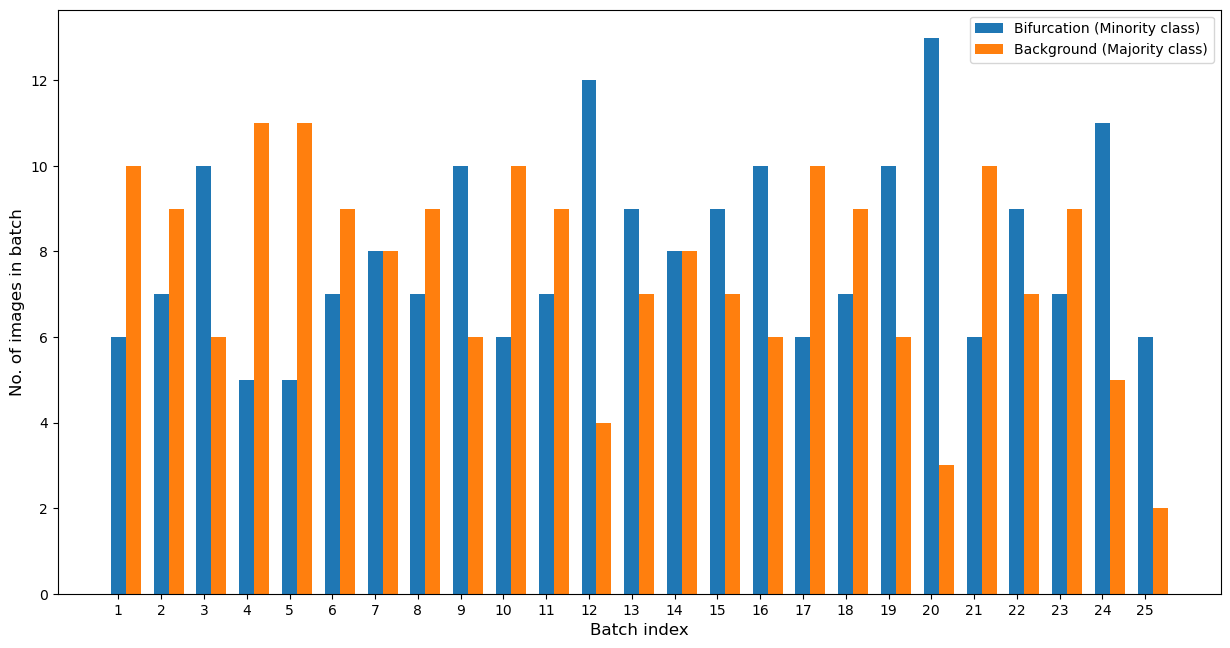

Avg Proportion of Bifurcation (Minority class) per batch: 0.804
Avg Proportion of Background (Majority class) per batch: 0.764
Num. unique images seen: 205/392


In [40]:
sampler= WeightedRandomSampler(weights=sample_weights, num_samples=len(ds), replacement=True)
dl = DataLoader(ds, sampler=sampler, batch_size=16)

class_0_batch_counts, class_1_batch_counts, idxs_seen = visualise_dataloader(dl,
                                                                             {0: "Bifurcation (Minority class)",
                                                                              1: "Background (Majority class)"})

In [41]:
from collections import Counter

image_counts_df = (
    pd.merge(
        imbalanced_train_df.reset_index(drop=True)
        .reset_index()
        .rename(columns={"index": "image_idx"}),
        pd.DataFrame.from_records(
            {"image_idx": k, "seen_count": v} for k, v in Counter(idxs_seen).items()
        ),
        how="left",
    )
    .fillna(0)
    .sort_values("seen_count", ascending=False)
    .reset_index(drop=True)
)

image_counts_df.query('label == "bifurcation"').head(10)


,image_idx,image,label,bbox,seen_count
0,47,PD092_34_aug2,bifurcation,"[0.0, 0.4858660459186914, 0.5788642148907874, ...",9.0
1,221,PD092_36_aug2,bifurcation,"[0.0, 0.5141339540813086, 0.5788642148907874, ...",8.0
2,263,PD003_41_aug0,bifurcation,"[0.0, 0.5529731894474317, 0.5128867556598733, ...",8.0
3,198,PD004_33_aug0,bifurcation,"[0.0, 0.5, 0.5, 0.047235375171426, 0.048380879...",8.0
4,371,PD004_34_aug0,bifurcation,"[0.0, 0.5076826891219316, 0.614073019822893, 0...",7.0
5,378,PD004_34_aug1,bifurcation,"[0.0, 0.5076826891219316, 0.614073019822893, 0...",7.0
6,205,PD004_33,bifurcation,"[0.0, 0.5076826891219316, 0.614073019822893, 0...",6.0
7,21,PD003_42_aug0,bifurcation,"[0.0, 0.4470268105525683, 0.48711324434012665,...",6.0
8,15,PD092_34_aug1,bifurcation,"[0.0, 0.5, 0.5, 0.05576577547351188, 0.0595668...",5.0
9,357,PD002_34,bifurcation,"[0.0, 0.4258173406086934, 0.552187145255256, 0...",5.0


In [42]:
val_df.label.value_counts()

label
bifurcation    3
Name: count, dtype: int64